In [2]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


plt.rcParams["figure.figsize"] = (8, 6)

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### Load a model trained with MRL

In [3]:
matry_model_name = "tomaarsen/mpnet-base-nli-matryoshka"
matry_model = SentenceTransformer(matry_model_name)
matry_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False, 'architecture': 'MPNetModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

### Basic Sentences Check with MRL

In [5]:
sentences = [
    "The stock market fell sharply today.",
    "The weather is sunny and warm."
]

emb = matry_model.encode(sentences, convert_to_numpy=True)
print("Embeddings shape:", emb.shape)   # Expect (2, 768)

Embeddings shape: (2, 768)


### Load a dataset to understand MRL
AG News as an easy themed dataset: 4 labels (World, Sports, Business, Sci/Tech)

Exercise A.1 – Load & peek at AG News

In [7]:
agnews = load_dataset("SetFit/ag_news", split="train")
print(agnews)
print(agnews[0])

train.jsonl:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 120000
})
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2, 'label_text': 'Business'}


#### ~20 sentences: 5 per theme (World, Sports, Business, Sci/Tech).

In [9]:
label_to_name = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

examples_per_label = 5
texts = []
labels = []

counts = {0: 0, 1: 0, 2: 0, 3: 0}

for ex in agnews:
    lbl = ex["label"]
    if counts[lbl] < examples_per_label:
        texts.append(ex["text"])
        labels.append(lbl)
        counts[lbl] += 1
    
    if all(c == examples_per_label for c in counts.values()):
        break

print("Collected:", len(texts), "sentences")
for t, l in zip(texts, labels):
    print(label_to_name[l], "→", t)


Collected: 20 sentences
Business → Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Business → Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Business → Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
Business → Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.
Business → Oil prices soar to 

### Experiment 1.1 – Similarity stability under truncation

#### Exercise 1.1.1 – Encode all sentences once

In [15]:
# Encode to full embeddings (e.g. 768-d)
full_emb = matry_model.encode(texts, convert_to_numpy=True, batch_size=16, show_progress_bar=True)
print("Full embedding shape:", full_emb.shape)  # (20, 768)
full_dim = full_emb.shape[1]
full_dim

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Full embedding shape: (20, 768)


768

#### Exercise 1.1.2 – Utility: truncate + L2 normalize

In [17]:
def truncate_and_normalize(embeddings: np.ndarray, d: int) -> np.ndarray:
    truncated = embeddings[:, :d]
    norms = np.linalg.norm(truncated, axis=1, keepdims=True) + 1e-12
    return truncated / norms

#### Exercise 1.1.3 – Compute cosine similarity matrices for different dims

In [18]:
dims = [64, 128, 256, 512, full_emb.shape[1]]

def cosine_sim_matrix(x: np.ndarray) -> np.ndarray:
    return x @ x.T   # rows are already L2-normalized

similarity_by_dim = {}

for d in dims:
    Xd = truncate_and_normalize(full_emb, d)
    S = cosine_sim_matrix(Xd)
    similarity_by_dim[d] = S
    print(f"d = {d}, similarity matrix shape:", S.shape)


d = 64, similarity matrix shape: (20, 20)
d = 128, similarity matrix shape: (20, 20)
d = 256, similarity matrix shape: (20, 20)
d = 512, similarity matrix shape: (20, 20)
d = 768, similarity matrix shape: (20, 20)


In [22]:
labels_arr = np.array(labels)

def theme_within_stats(S: np.ndarray, labels_arr: np.ndarray, label_id: int):
    idx = np.where(labels_arr == label_id)[0]
    sims = []
    for i in range(len(idx)):
        for j in range(i+1, len(idx)):
            sims.append(S[idx[i], idx[j]])
    sims = np.array(sims)
    return sims.mean(), sims.std()

theme_stats = {label_id: {} for label_id in label_to_name.keys()}

for d in dims:
    S = similarity_by_dim[d]
    for label_id in label_to_name.keys():
        mean_sim, std_sim = theme_within_stats(S, labels_arr, label_id)
        theme_stats[label_id][d] = (mean_sim, std_sim)

theme_stats  # just to inspect


{0: {64: (np.float32(0.42609772), np.float32(0.13380939)),
  128: (np.float32(0.3628713), np.float32(0.12610519)),
  256: (np.float32(0.32887492), np.float32(0.13073649)),
  512: (np.float32(0.3414457), np.float32(0.09756905)),
  768: (np.float32(0.3459696), np.float32(0.092978284))},
 1: {64: (np.float32(0.41568786), np.float32(0.15029167)),
  128: (np.float32(0.34755224), np.float32(0.1443199)),
  256: (np.float32(0.34994885), np.float32(0.10915229)),
  512: (np.float32(0.32353234), np.float32(0.100637935)),
  768: (np.float32(0.32914287), np.float32(0.10690577))},
 2: {64: (np.float32(0.25474295), np.float32(0.14394824)),
  128: (np.float32(0.27246508), np.float32(0.121297374)),
  256: (np.float32(0.23541951), np.float32(0.13766083)),
  512: (np.float32(0.26460978), np.float32(0.12300315)),
  768: (np.float32(0.28151482), np.float32(0.11459522))},
 3: {64: (np.float32(0.37639552), np.float32(0.146653)),
  128: (np.float32(0.33698958), np.float32(0.13349108)),
  256: (np.float32(0.30

#### Exercise 1.1.4 – Measure within-theme vs across-theme similarity

In [19]:
labels_arr = np.array(labels)

def within_across_stats(S: np.ndarray, labels_arr: np.ndarray):
    n = len(labels_arr)
    within = []
    across = []
    for i in range(n):
        for j in range(i+1, n):
            if labels_arr[i] == labels_arr[j]:
                within.append(S[i, j])
            else:
                across.append(S[i, j])
    return np.mean(within), np.mean(across)

for d in dims:
    S = similarity_by_dim[d]
    w, a = within_across_stats(S, labels_arr)
    print(f"d={d:3d}: within={w:.3f}, across={a:.3f}, gap={w-a:.3f}")


d= 64: within=0.368, across=0.155, gap=0.213
d=128: within=0.330, across=0.154, gap=0.176
d=256: within=0.305, across=0.134, gap=0.171
d=512: within=0.301, across=0.145, gap=0.155
d=768: within=0.312, across=0.161, gap=0.151


#### Exercise 1.1.5 – K-means clustering by dim

In [20]:
k = 4
for d in dims:
    Xd = truncate_and_normalize(full_emb, d)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(Xd)
    
    print(f"\nDim = {d}")
    for c in range(k):
        cluster_idxs = np.where(clusters == c)[0]
        cluster_labels = [label_to_name[labels[i]] for i in cluster_idxs]
        print(f"Cluster {c}: size={len(cluster_idxs)}, label counts=",
              {lab: cluster_labels.count(lab) for lab in set(cluster_labels)})



Dim = 64
Cluster 0: size=6, label counts= {'World': 5, 'Business': 1}
Cluster 1: size=5, label counts= {'Sports': 5}
Cluster 2: size=6, label counts= {'Sci/Tech': 5, 'Business': 1}
Cluster 3: size=3, label counts= {'Business': 3}

Dim = 128
Cluster 0: size=5, label counts= {'Sci/Tech': 2, 'Business': 3}
Cluster 1: size=5, label counts= {'Sports': 5}
Cluster 2: size=6, label counts= {'World': 5, 'Business': 1}
Cluster 3: size=4, label counts= {'Sci/Tech': 3, 'Business': 1}

Dim = 256
Cluster 0: size=5, label counts= {'World': 4, 'Business': 1}
Cluster 1: size=5, label counts= {'Sports': 5}
Cluster 2: size=7, label counts= {'Sci/Tech': 5, 'Business': 2}
Cluster 3: size=3, label counts= {'World': 1, 'Business': 2}

Dim = 512
Cluster 0: size=3, label counts= {'Sci/Tech': 3}
Cluster 1: size=7, label counts= {'World': 5, 'Business': 2}
Cluster 2: size=5, label counts= {'Sports': 5}
Cluster 3: size=5, label counts= {'Sci/Tech': 2, 'Business': 3}

Dim = 768
Cluster 0: size=5, label counts= {'

### Plots to understand effect of MRL

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Choose theme
theme_name = "World"
theme_label = [k for k, v in label_to_name.items() if v == theme_name][0]

# Indices of sentences in that theme
theme_idxs = [i for i, l in enumerate(labels) if l == theme_label]
print("Theme:", theme_name)
print("Theme indices:", theme_idxs)

# Pick ONE anchor sentence (e.g., first Sports sentence)
anchor_idx = theme_idxs[0]
print("\nAnchor index:", anchor_idx)
print("Anchor text:", texts[anchor_idx])


Theme: World
Theme indices: [15, 16, 17, 18, 19]

Anchor index: 15
Anchor text: Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.


In [45]:
# For each other sentence in the theme, we collect similarity across dims
anchor_sims_per_target = {}  # target_idx -> list of sims across dims
mean_sims = []               # mean similarity across all same-theme targets per d

for target_idx in theme_idxs:
    if target_idx == anchor_idx:
        continue
    sims = []
    for d in dims:
        S = similarity_by_dim[d]
        sims.append(S[anchor_idx, target_idx])
    anchor_sims_per_target[target_idx] = sims

# Also compute mean similarity to all same-theme sentences at each d
for dim_idx, d in enumerate(dims):
    vals_at_d = [sims[dim_idx] for sims in anchor_sims_per_target.values()]
    mean_sims.append(np.mean(vals_at_d))


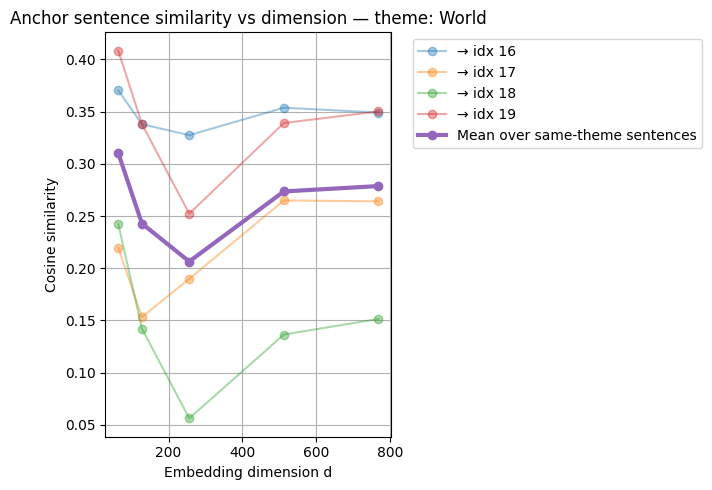

In [46]:
plt.figure(figsize=(7, 5))

# One line per "other sentence" in the same theme
for target_idx, sims in anchor_sims_per_target.items():
    plt.plot(dims, sims, marker='o', alpha=0.4,
             label=f"→ idx {target_idx}")

# Mean curve (bold)
plt.plot(dims, mean_sims, marker='o', linewidth=3,
         label="Mean over same-theme sentences")

plt.xlabel("Embedding dimension d")
plt.ylabel("Cosine similarity")
plt.title(f"Anchor sentence similarity vs dimension — theme: {theme_name}")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [47]:
print("Anchor:", texts[anchor_idx], "\n")

for target_idx, sims in anchor_sims_per_target.items():
    print(f"Target idx {target_idx} ({texts[target_idx]})")
    for d, s in zip(dims, sims):
        print(f"  d={d:3d}: sim={s:.3f}")
    print()


Anchor: Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years. 

Target idx 16 (S.Koreans Clash with Police on Iraq Troop Dispatch (Reuters) Reuters - South Korean police used water cannon in\central Seoul Sunday to disperse at least 7,000 protesters\urging the government to reverse a controversial decision to\send more troops to Iraq.)
  d= 64: sim=0.370
  d=128: sim=0.338
  d=256: sim=0.327
  d=512: sim=0.354
  d=768: sim=0.349

Target idx 17 (Palestinians in Israeli Jails Start Hunger Strike (Reuters) Reuters - Thousands of Palestinian\prisoners in Israeli jails began a hunger strike for better\conditions Sunday, but Israel's security minister said he\didn't care if they starved to death.)
  d= 64: sim=0.220
  d=128: sim=0.153
  d=256: sim=0.190
  d

In [48]:
# sports_id = 1  # adjust if your mapping is different
# sports_name = label_to_name[sports_id]

# dims_sorted = sorted(theme_stats[sports_id].keys())
# means = [theme_stats[sports_id][d][0] for d in dims_sorted]
# stds  = [theme_stats[sports_id][d][1] for d in dims_sorted]

# plt.figure(figsize=(5,4))
# plt.errorbar(
#     dims_sorted,
#     means,
#     yerr=stds,
#     marker="o",
#     capsize=3,
# )
# plt.xscale("log", base=2)
# plt.xlabel("Embedding dimension (d)")
# plt.ylabel(f"Mean within-{sports_name} similarity")
# plt.title(f"Within-theme similarity vs dimension ({sports_name})")
# plt.grid(True, which="both", linestyle="--", alpha=0.4)
# plt.tight_layout()
# plt.show()


In [49]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(6,4))

# for label_id, theme_name in label_to_name.items():
#     dims_sorted = sorted(theme_stats[label_id].keys())
#     means = [theme_stats[label_id][d][0] for d in dims_sorted]
#     stds  = [theme_stats[label_id][d][1] for d in dims_sorted]

#     plt.errorbar(
#         dims_sorted,
#         means,
#         yerr=stds,
#         marker="o",
#         capsize=3,
#         label=theme_name,
#     )

# plt.xscale("log", base=2)  # optional: 64, 128, 256, 512, 768 look nicer
# plt.xlabel("Embedding dimension (d)")
# plt.ylabel("Mean within-theme cosine similarity")
# plt.title("Within-theme similarity vs dimension (Matryoshka)")
# plt.grid(True, which="both", linestyle="--", alpha=0.4)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [50]:
from numpy.linalg import norm

def truncate_and_normalize(embeddings, d):
    """
    embeddings: (N, D_full)
    d: truncation dimension (<= D_full)
    Returns: (N, d) normalized embeddings
    """
    emb_trunc = embeddings[:, :d]
    # L2 normalize
    norms = norm(emb_trunc, axis=1, keepdims=True) + 1e-8
    emb_norm = emb_trunc / norms
    return emb_norm

def cosine_similarity_matrix(embeddings):
    """
    embeddings: (N, d), assumed L2-normalized
    Returns: (N, N) cosine similarity matrix
    """
    return np.matmul(embeddings, embeddings.T)


In [51]:
truncate_dims = [64, 128, 256, 512, full_dim]

N = len(all_sentences)
theme_array = np.array(themes)

NameError: name 'all_sentences' is not defined

In [ ]:

results = []

for d in truncate_dims:
    emb_d = truncate_and_normalize(emb_full, d)
    sim_mat = cosine_similarity_matrix(emb_d)
    
    # Collect within-theme and across-theme similarities
    within_sims = []
    across_sims = []
    
    for i in range(N):
        for j in range(i + 1, N):
            same_theme = (theme_array[i] == theme_array[j])
            if same_theme:
                within_sims.append(sim_mat[i, j])
            else:
                across_sims.append(sim_mat[i, j])
    
    results.append({
        "dim": d,
        "mean_within": float(np.mean(within_sims)),
        "mean_across": float(np.mean(across_sims)),
        "std_within": float(np.std(within_sims)),
        "std_across": float(np.std(across_sims)),
    })

results


In [ ]:
dims = [r["dim"] for r in results]
within = [r["mean_within"] for r in results]
across = [r["mean_across"] for r in results]

plt.figure()
plt.plot(dims, within, marker="o", label="Within-theme similarity")
plt.plot(dims, across, marker="o", label="Across-theme similarity")
plt.xlabel("Truncation dimension (d)")
plt.ylabel("Mean cosine similarity")
plt.title("Matryoshka: Within vs Across Theme Similarities")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def plot_similarity_heatmap(embeddings, title):
    emb_norm = truncate_and_normalize(embeddings, embeddings.shape[1])
    sim_mat = cosine_similarity_matrix(emb_norm)
    
    plt.figure(figsize=(8, 7))
    sns.heatmap(sim_mat, vmin=-1, vmax=1, cmap="coolwarm", annot=False)
    plt.title(title)
    plt.xlabel("Sentence index")
    plt.ylabel("Sentence index")
    plt.show()

# For a specific d, we can just truncate emb_full then plot
d_small = 64
emb_64 = truncate_and_normalize(emb_full, d_small)
sim_64 = cosine_similarity_matrix(emb_64)

plt.figure(figsize=(8, 7))
sns.heatmap(sim_64, vmin=-1, vmax=1, cmap="coolwarm")
plt.title(f"Cosine Similarity (d={d_small})")
plt.xlabel("Sentence index")
plt.ylabel("Sentence index")
plt.show()

# And for full dim:
emb_full_norm = truncate_and_normalize(emb_full, full_dim)
sim_full = cosine_similarity_matrix(emb_full_norm)

plt.figure(figsize=(8, 7))
sns.heatmap(sim_full, vmin=-1, vmax=1, cmap="coolwarm")
plt.title(f"Cosine Similarity (d={full_dim})")
plt.xlabel("Sentence index")
plt.ylabel("Sentence index")
plt.show()
